# Quickstart or _"How to get 100% return per year"_

First, do some initialization and set the debugging level to `debug` to see the progress of computation.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

import universal as up
from universal import tools, algos
from universal.algos import *

sns.set_context("notebook")
plt.rcParams["figure.figsize"] = (16, 8)

In [2]:
# Ignore logged warnings
import logging
logging.getLogger().setLevel(logging.ERROR)

Let's try to replicate the results of B. Li and S. Hoi from their article [On-Line Portfolio Selection with Moving Average Reversion](http://arxiv.org/abs/1206.4626). They claim superior performance on several datasets using their OLMAR algorithm. These datasets are available in the `data/` directory in `.csv` format. These are all raw prices and artificial tickers. We can start with NYSE stocks from the period 1/1/1985 - 30/6/2010.

<Axes: >

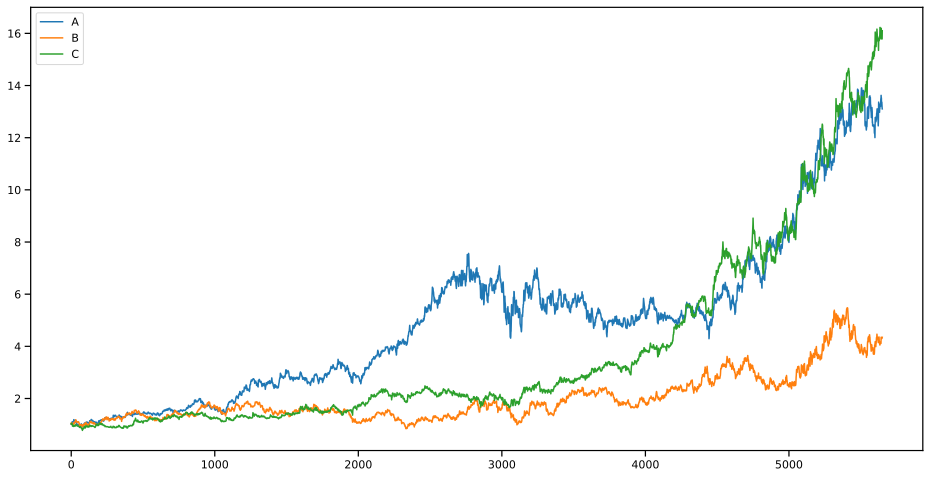

In [3]:
# Load data using the tools module
data = tools.dataset('nyse_o')

# Plot the first three as an example
data.iloc[:,:3].plot()

Now we need an implementation of the OLMAR algorithm. Fortunately, it is already implemented in the `algos` module, so all we have to do is load it and set its parameters. The authors recommend a lookback window $w = 5$ and threshold $\epsilon = 10$ (these are the default parameters anyway). Just call the `run` method on our data to get results for analysis.

In [4]:
# Set algo parameters
algo = algos.OLMAR(window=5, eps=10)

# Run
result = algo.run(data)

Ok, let's see some results. First, print some basic summary metrics and plot portfolio equity with UCRP (uniform constant rebalanced portfolio).

Summary:
    Profit factor: 1.89
    Sharpe ratio: 3.34 ± 0.19
    Ulcer index: 23.24
    Information ratio (wrt benchmark): 3.27
    Benchmark Sharpe: 1.16 ± 0.21
    Appraisal ratio (wrt benchmark): 3.13 ± 0.21
    Beta / Alpha: 1.56 / 165.627%
    Annualized return: 189.87%
    Annualized volatility: 56.79%
    Longest drawdown: 185 days
    Max drawdown: 46.29%
    Winning days: 58.2%
    Annual turnover: 339.6
    Utility (q=0.5): 122.53%
    Utility (q=0.7): 141.77%
    Utility (q=1.0): 156.20%
    Utility (q=2.0): 173.03%
        


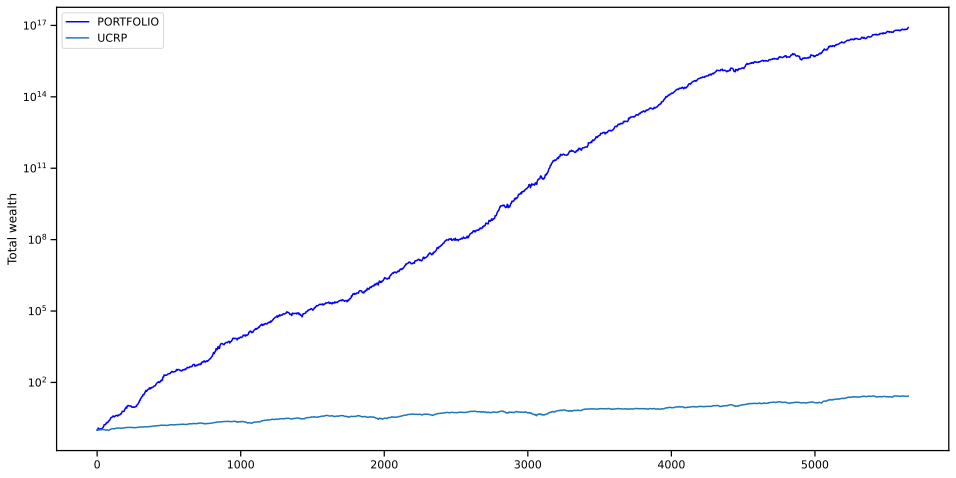

In [5]:
print(result.summary())
result.plot(weights=False, assets=False, ucrp=True, logy=True);

That seems really impressive; in fact, it looks too good to be true. Let's see how individual stocks contribute to portfolio equity and disable the legend to keep the graph clean.

<Axes: >

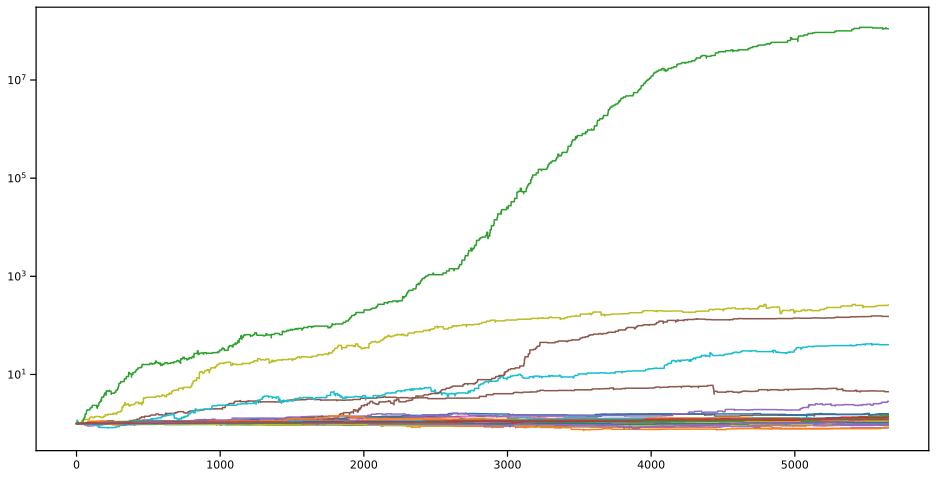

In [6]:
result.plot_decomposition(legend=False, logy=True)

As you can see, almost all wealth comes from a single stock (don't forget it has a logarithmic scale!). So if we used just 5 of all these stocks, we would get almost the same equity as if we used all of them. To stress test the strategy, we can remove that stock and rerun the algorithm.

Summary:
    Profit factor: 1.55
    Sharpe ratio: 2.48 ± 0.20
    Ulcer index: 12.70
    Information ratio (wrt benchmark): 2.36
    Benchmark Sharpe: 1.12 ± 0.21
    Appraisal ratio (wrt benchmark): 2.21 ± 0.21
    Beta / Alpha: 1.48 / 97.131%
    Annualized return: 119.24%
    Annualized volatility: 48.01%
    Longest drawdown: 202 days
    Max drawdown: 45.91%
    Winning days: 56.5%
    Annual turnover: 338.3
    Utility (q=0.5): 72.02%
    Utility (q=0.7): 85.51%
    Utility (q=1.0): 95.63%
    Utility (q=2.0): 107.43%
        


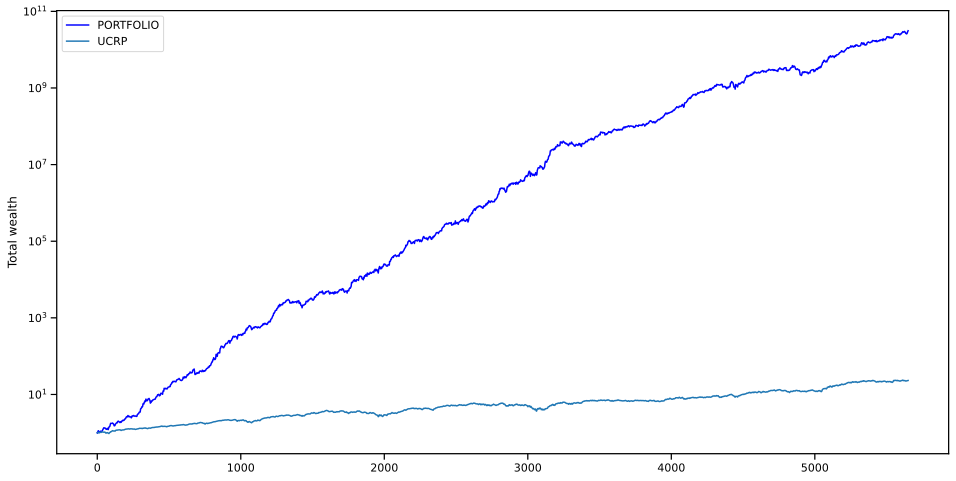

In [7]:
# Find the name of the most profitable asset
most_profitable = result.equity_decomposed.iloc[-1].idxmax()

# Rerun the algorithm on data without it
result_without = algo.run(data.drop(columns=[most_profitable]))

# And print results
print(result_without.summary())
result_without.plot(weights=False, assets=False, ucrp=True, logy=True);

We lost about 7 orders of wealth, but the results are more realistic now. Let's move on and try adding fees of 0.1% per transaction (we pay \\$1 for every \\$1000 of stocks bought or sold).

Summary:
    Profit factor: 1.35
    Sharpe ratio: 1.78 ± 0.20
    Ulcer index: 6.79
    Information ratio (wrt benchmark): 1.59
    Benchmark Sharpe: 1.12 ± 0.21
    Appraisal ratio (wrt benchmark): 1.44 ± 0.21
    Beta / Alpha: 1.48 / 63.323%
    Annualized return: 85.41%
    Annualized volatility: 48.08%
    Longest drawdown: 382 days
    Max drawdown: 50.21%
    Winning days: 50.4%
    Annual turnover: 338.3
    Utility (q=0.5): 38.61%
    Utility (q=0.7): 51.98%
    Utility (q=1.0): 62.01%
    Utility (q=2.0): 73.71%
        


[<Axes: ylabel='Total wealth'>]

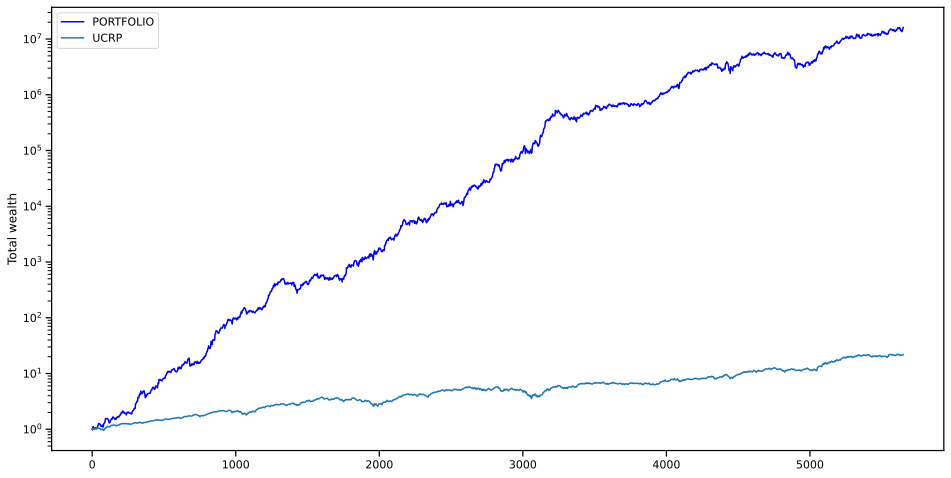

In [8]:
result_without.fee = 0.001
print(result_without.summary())
result_without.plot(weights=False, assets=False, ucrp=True, logy=True)

Results still hold, although our Sharpe ratio decreased from 3.14 to 1.56 and annualized return from 466% to 109%. Now, some of you trained in quantitative finance might start asking: "_Isn't there some [survivorship bias](http://en.wikipedia.org/wiki/Survivorship_bias)?_". Yes, there is. In fact, a huge one considering that we have almost 25 years of data and a mean-reversion type of strategy.

# Testing Yahoo data

Let's see whether the algo works on recent data, too. First, download closing prices of several (randomly chosen) stocks from Yahoo.

<Axes: xlabel='Date'>

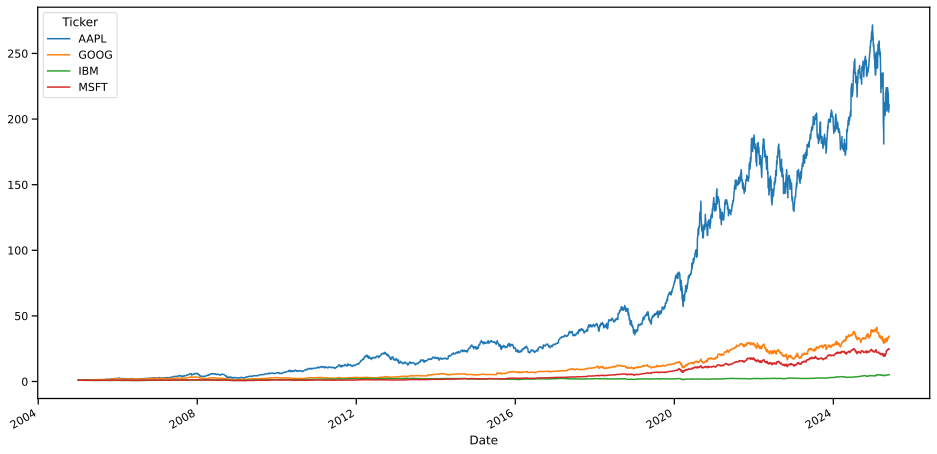

In [9]:
import yfinance as yf

# Load data from Yahoo
yahoo_data_raw = yf.download(['MSFT', 'IBM', 'AAPL', 'GOOG'], start=dt.datetime(2005,1,1), auto_adjust=False, multi_level_index=False, progress=False)
yahoo_data = yahoo_data_raw['Adj Close']

# Plot normalized prices of these stocks
(yahoo_data / yahoo_data.iloc[0,:]).plot()

Instead of using fixed parameters, we will test several `window` parameters with the function `run_combination`. It is the same as `run`, just use it as a classmethod and use lists for combinations of values. `run_combination` returns a list of results which can be used similarly to `result`.

Summary for window=3:
    Profit factor: 1.08
    Sharpe ratio: 0.55 ± 0.22
    Ulcer index: 1.01
    Information ratio (wrt benchmark): -0.23
    Benchmark Sharpe: 0.94 ± 0.22
    Appraisal ratio (wrt benchmark): -0.29 ± 0.22
    Beta / Alpha: 1.06 / -5.508%
    Annualized return: 16.55%
    Annualized volatility: 30.23%
    Longest drawdown: 649 days
    Max drawdown: 51.24%
    Winning days: 51.9%
    Annual turnover: 285.1
    Utility (q=0.5): -1.74%
    Utility (q=0.7): 3.49%
    Utility (q=1.0): 7.41%
    Utility (q=2.0): 11.98%
        
Summary for window=5:
    Profit factor: 1.11
    Sharpe ratio: 0.71 ± 0.22
    Ulcer index: 1.54
    Information ratio (wrt benchmark): 0.04
    Benchmark Sharpe: 0.94 ± 0.22
    Appraisal ratio (wrt benchmark): -0.04 ± 0.22
    Beta / Alpha: 1.07 / -0.757%
    Annualized return: 21.53%
    Annualized volatility: 30.20%
    Longest drawdown: 807 days
    Max drawdown: 48.12%
    Winning days: 52.5%
    Annual turnover: 213.0
    Utility (q=0.5):

<Axes: xlabel='Date', ylabel='Total wealth'>

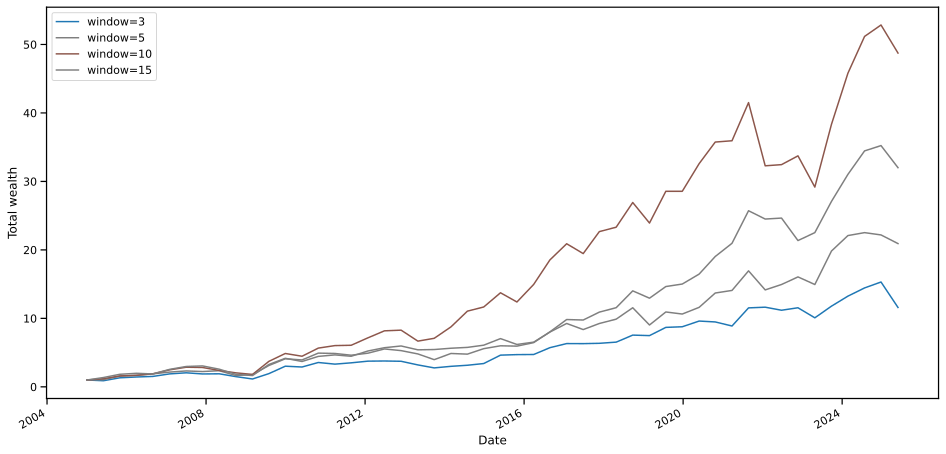

In [10]:
list_result = algos.OLMAR.run_combination(yahoo_data, window=[3,5,10,15], eps=10)
print(list_result.summary())
list_result.plot()

Since we don't know the best parameters in hindsight, we will invest equal money in each of them at the beginning and let them run. This is called a _buy and hold_ strategy. Portfolio equities in `list_result` can be regarded as stock prices and used as input for a new algo (_buy and hold_ in this case). This way you can chain algorithms however you like, for example OLMAR on OLMAR, etc.

To compare it with individual assets or a uniform constant rebalanced portfolio, use the parameters `assets` and `ucrp`.

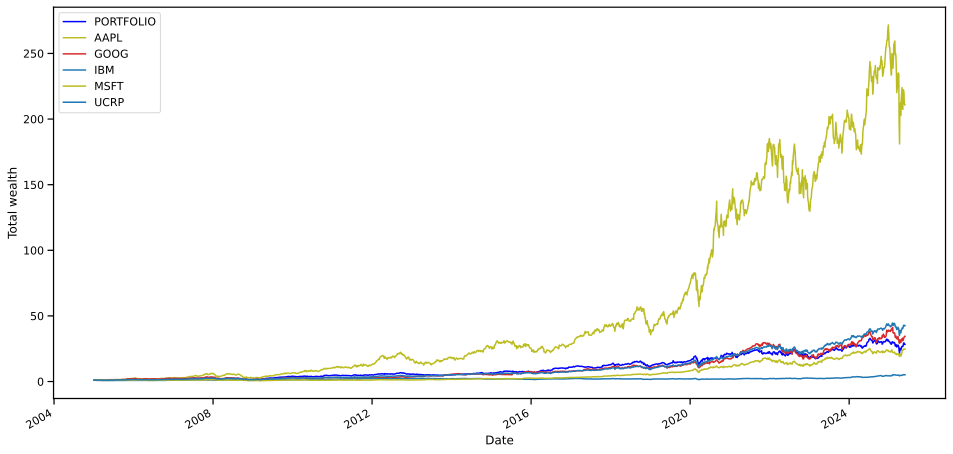

In [11]:
# Run buy and hold on OLMAR results and show its equity together with original assets
algos.BAH().run(list_result).plot(assets=True, weights=False, ucrp=True);

Ok, so that was enough for the start. There are plenty of other algorithms in the `algos` module collected from research papers about online portfolios, including the famous [Universal portfolio](http://en.wikipedia.org/wiki/Universal_portfolio_algorithm) by Thomas Cover.

# How to write your own algorithm

The entire package is actually pretty simple. Algorithms are subclasses of the base `Algo` class, and methods for reporting, plotting, and analyzing are built on top of this class. I will illustrate it on this mean-reversion strategy:

1. Use the logarithm of price.
2. Calculate the difference $\delta_i$ between the current price of the $i$-th stock and its moving average of $n$ days.
3. If $\delta_i > 0$, assign zero portfolio weight $w_i = 0$ for the $i$-th stock.
4. If $\delta_i < 0$, assign weight $w_i = -\delta_i$ for the $i$-th stock.
5. Normalize all weights so that $\sum w_i = 1$.

The idea is that badly performing stocks will revert to their mean and have higher returns than those above their mean. Here is the complete code; comments should be self-explanatory.

In [12]:
from universal.algo import Algo
import numpy as np

class MeanReversion(Algo):
    # Use logarithm of prices
    PRICE_TYPE = 'log'

    def __init__(self, n):
        # Length of moving average
        self.n = n
        # step function will be called after min_history days
        super().__init__(min_history=n)

    def init_weights(self, cols):
        # Use zero weights for start
        return pd.Series(np.zeros(len(cols)), cols)

    def step(self, x, last_b, history):
        # Calculate moving average
        ma = history.iloc[-self.n:].mean()

        # Weights
        delta = x - ma
        w = np.maximum(-delta, 0.)

        # Normalize so that they sum to 1
        return w / sum(w)

That's all. Now let's try it on NYSE data.

Summary:
    Profit factor: 1.46
    Sharpe ratio: 2.13 ± 0.20
    Ulcer index: 4.84
    Information ratio (wrt benchmark): 1.94
    Benchmark Sharpe: 1.16 ± 0.21
    Appraisal ratio (wrt benchmark): 1.81 ± 0.21
    Beta / Alpha: 1.15 / 32.163%
    Annualized return: 50.05%
    Annualized volatility: 23.47%
    Longest drawdown: 808 days
    Max drawdown: 41.29%
    Winning days: 52.4%
    Annual turnover: 361.7
    Utility (q=0.5): 38.84%
    Utility (q=0.7): 42.04%
    Utility (q=1.0): 44.44%
    Utility (q=2.0): 47.25%
        


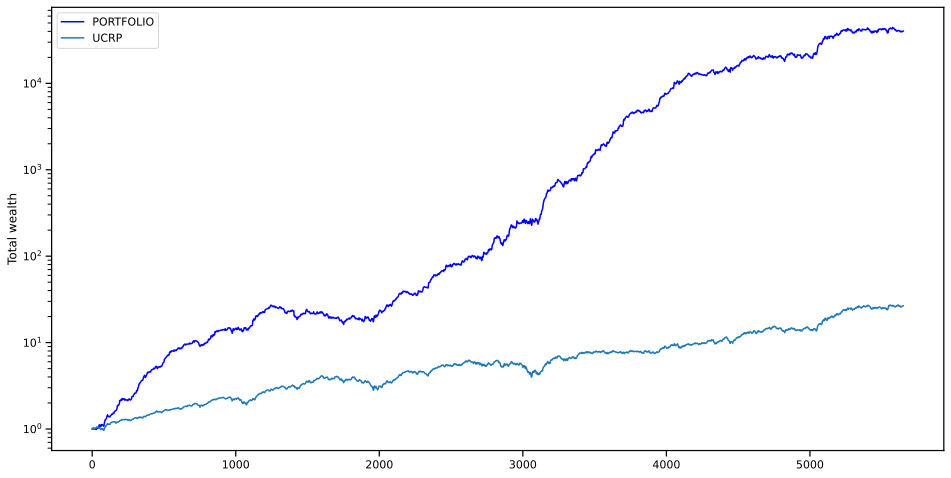

In [13]:
mr = MeanReversion(n=20)
result = mr.run(data)

print(result.summary())
result.plot(assets=False, logy=True, weights=False, ucrp=True);

Not bad considering how simple that strategy is. The next step could be performance optimization. To profile your strategy, you can use the function `profile` in `universal.tools`, which profiles the code using the fantastic [line_profiler](http://pythonhosted.org/line_profiler/). After identifying the most critical parts of the code, you have two options. Either optimize your `step` function (using tools such as [weave](http://docs.scipy.org/doc/scipy/reference/tutorial/weave.html), [numba](http://numba.pydata.org/), [theano](http://deeplearning.net/software/theano/) or [cython](http://cython.org/)), or subclass the `weights` method if your code can be easily vectorized (beware the forward bias!). 